In [1]:
import uproot
import numpy as np
from scipy.stats import gamma, kstest,expon
import matplotlib.pyplot as plt
import pandas as pd
import mplhep as hep
from scipy import stats

import os
plt.style.use(hep.style.ATLAS)

<>:48: SyntaxWarning: invalid escape sequence '\T'
<>:48: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_85109/2660972107.py:48: SyntaxWarning: invalid escape sequence '\T'
  f'scale ($\Theta$): {fit_scale:.2f} ± {err_scale:.2f}\n'
/tmp/ipykernel_85109/2660972107.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.array(uproot.open(filename)["Tracker"]["AccumulatedDistance_mm"].array())


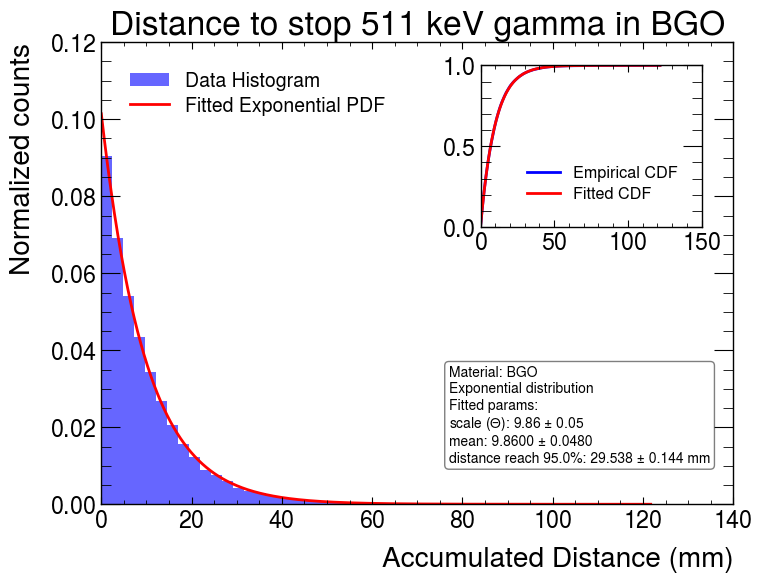


Exponential for BGO:
Average KS p-value: 0.6569
Median: 0.6981, Fraction >0.05: 0.99


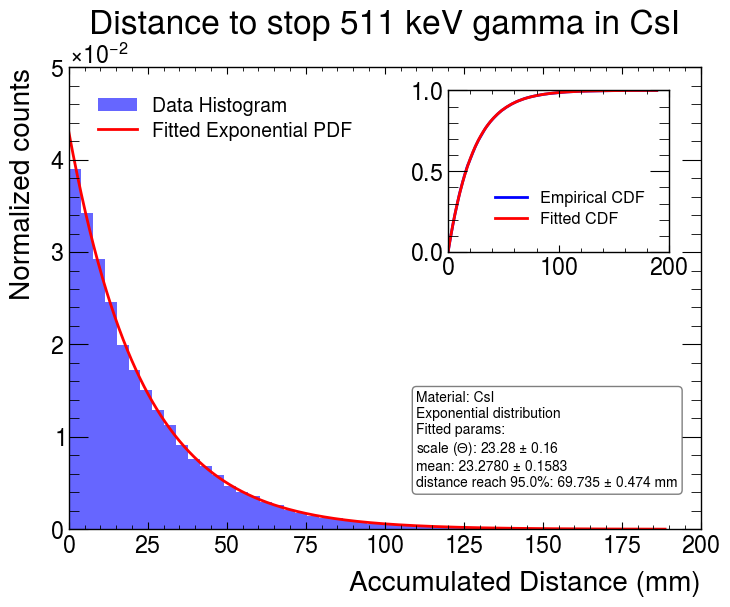


Exponential for CsI:
Average KS p-value: 0.6606
Median: 0.7029, Fraction >0.05: 1.00


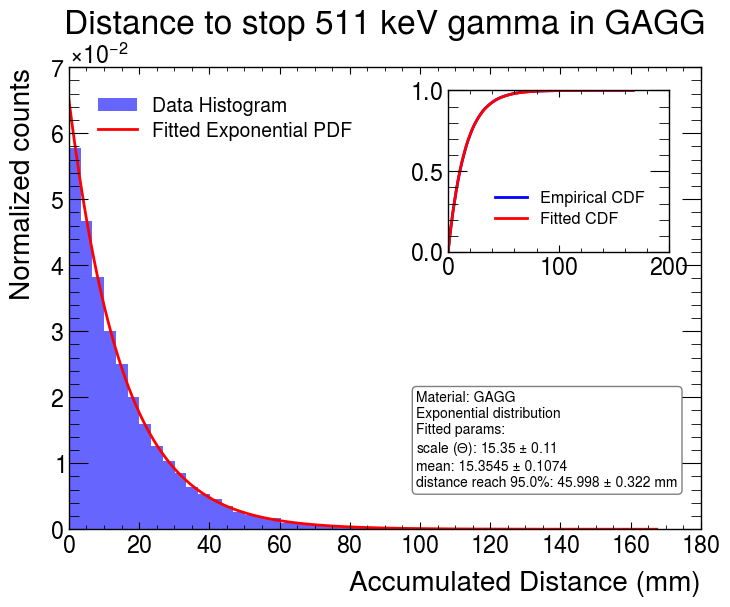


Exponential for GAGG:
Average KS p-value: 0.6571
Median: 0.7000, Fraction >0.05: 1.00


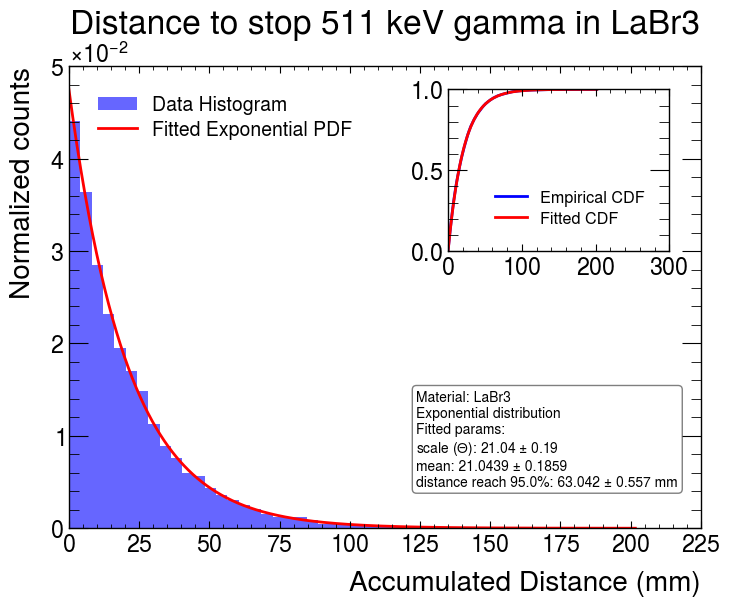


Exponential for LaBr3:
Average KS p-value: 0.6423
Median: 0.6768, Fraction >0.05: 0.99


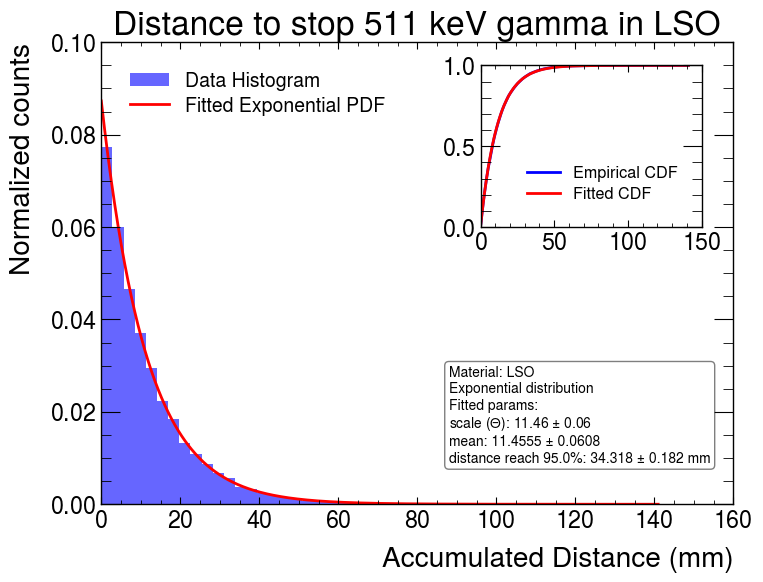


Exponential for LSO:
Average KS p-value: 0.6646
Median: 0.7111, Fraction >0.05: 0.99


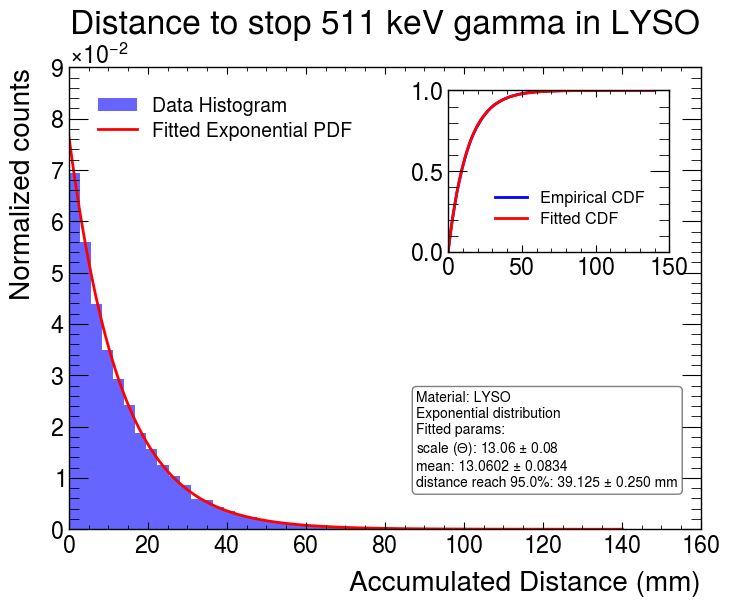


Exponential for LYSO:
Average KS p-value: 0.6619
Median: 0.7112, Fraction >0.05: 1.00


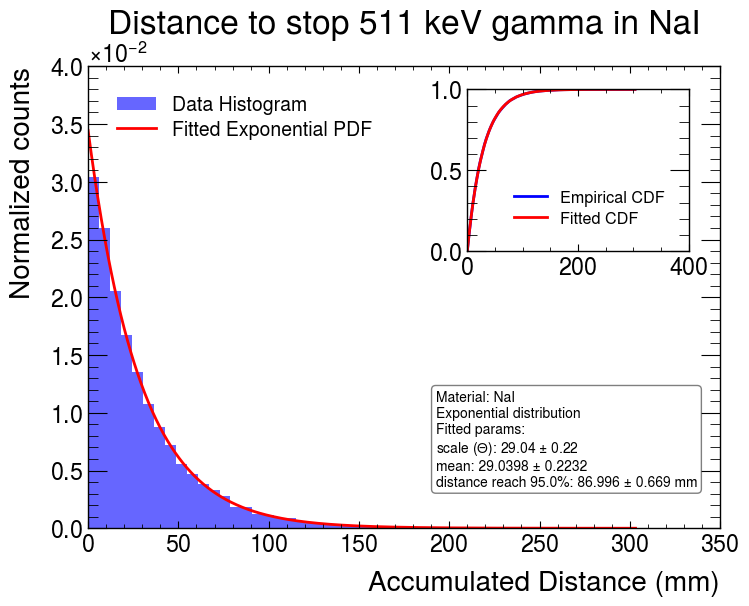


Exponential for NaI:
Average KS p-value: 0.6629
Median: 0.7145, Fraction >0.05: 0.99


In [5]:
file_names = ["BGO.root","CsI.root","GAGG.root","LaBr3.root","LSO.root","LYSO.root","NaI.root"]
n=0.95
for filename in file_names:
    MaterialName = filename.split(".")[0]
    data = np.array(uproot.open(filename)["Tracker"]["AccumulatedDistance_mm"].array())
    # Main fit on full data
    fit_loc, fit_scale = expon.fit(data, floc=0)
    fit_mean = fit_scale
    # 99% quantile from main fit
    dist_99 = expon.ppf(n, loc=fit_loc, scale=fit_scale)
    # Bootstrap for errors (M=500 resamples with replacement, full size)
    num_boot = 500
    boot_scales = np.zeros(num_boot)
    boot_means = np.zeros(num_boot)
    boot_dist99 = np.zeros(num_boot)
    for b in range(num_boot):
        boot_data = np.random.choice(data, size=len(data), replace=True)
        b_loc, b_scale = expon.fit(boot_data, floc=0)
        boot_scales[b] = b_scale
        boot_means[b] = b_scale
        boot_dist99[b] = expon.ppf(n, loc=b_loc, scale=b_scale)
    # Errors as std dev of bootstrap distributions
    err_scale = np.std(boot_scales)
    err_mean = np.std(boot_means)
    err_dist99 = np.std(boot_dist99)
    # Plot histogram and PDF
    fig, ax1 = plt.subplots()
    ax1.hist(data, bins=50, density=True, alpha=0.6, color='blue', label='Data Histogram')
    x = np.linspace(0, max(data), 1000)
    pdf_fitted = expon.pdf(x, loc=fit_loc, scale=fit_scale)
    ax1.plot(x, pdf_fitted, 'r-', label='Fitted Exponential PDF')
    ax1.set_xlabel('Accumulated Distance (mm)')
    ax1.set_ylabel('Normalized counts')
    ax1.legend(loc='upper left')
    # CDF inset
    ax2 = ax1.inset_axes([0.6, 0.6, 0.35, 0.35])
    sorted_data = np.sort(data)
    cdf_emp = np.arange(len(data)) / float(len(data))
    cdf_fit = expon.cdf(sorted_data, loc=fit_loc, scale=fit_scale)
    ax2.plot(sorted_data, cdf_emp, 'b-', label='Empirical CDF')
    ax2.plot(sorted_data, cdf_fit, 'r-', label='Fitted CDF')
    ax2.set_ylim(0, 1)
    ax2.legend(fontsize='small')
    # Text box with params and errors
    textstr = (f'Material: {MaterialName}\n'
               f'Exponential distribution\n'
               f'Fitted params:\n'
               f'scale ($\Theta$): {fit_scale:.2f} ± {err_scale:.2f}\n'
               f'mean: {fit_mean:.4f} ± {err_mean:.4f}\n'
               f'distance reach {n*100}%: {dist_99:.3f} ± {err_dist99:.3f} mm')
    ax1.text(0.55, 0.30, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.title("Distance to stop 511 keV gamma in " + MaterialName)
    plt.savefig(f'plots/Exponential_Fit_{MaterialName}.png', dpi=300)
    plt.show()
    # Optional: subsample p-values (kept as is)
    subsample_size = 1000
    num_subsamples = 1000
    expon_p_values = []
    for _ in range(num_subsamples):
        subsample = np.random.choice(data, size=subsample_size, replace=False)
        g_loc, g_scale = expon.fit(subsample, floc=0)
        ks = stats.kstest(subsample, 'expon', args=(g_loc, g_scale))
        expon_p_values.append(ks.pvalue)
    print("\nExponential for " + MaterialName + ":")
    print(f"Average KS p-value: {np.mean(expon_p_values):.4f}")
    print(f"Median: {np.median(expon_p_values):.4f}, Fraction >0.05: {np.mean(np.array(expon_p_values) > 0.05):.2f}")